In [2]:
import rootutils
from pathlib import Path

rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)
import numpy as np
from src.viaABC.systems import LotkaVolterra
from src.models.lightning_module import PreTrainLightning
from src.models.MAE.model import MaskedAutoencoderViT
import torch

from src.utils.viaABC_utils.inference_utils import load_pretrained_model
from hydra.utils import instantiate
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt

/home/jp4474/viaABC/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

chkpt_path = "/home/jp4474/viaABC/logs/train/runs/VAE"

with initialize_config_dir(config_dir=os.path.join(chkpt_path, ".hydra")):
    cfg = compose(config_name="config")

/tmp/ipykernel_1201058/2392609725.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=os.path.join(chkpt_path, ".hydra")):


In [4]:
model = instantiate(cfg.model)
# Load raw checkpoint
ckpt = torch.load(Path(chkpt_path) / "checkpoints/last.ckpt", map_location="cpu", weights_only=False)

state = ckpt["state_dict"]


# 1. strip 'model.' prefix (Lightning adds this)
# 2. strip '_orig_mod.' from DDP/Fabric models  
fixed_state = {}

for k, v in state.items():
    new_k = k

    # remove top-level "model."
    if new_k.startswith("model."):
        new_k = new_k[len("model."):]

    # remove DDP wrapper
    if new_k.startswith("_orig_mod."):
        new_k = new_k[len("_orig_mod."):]

    fixed_state[new_k] = v

missing, unexpected = model.model.load_state_dict(fixed_state, strict=False)

print("Missing:", missing)
print("Unexpected:", unexpected)
print("✓ Loaded successfully with prefix-stripping")

Missing: []
Unexpected: []
✓ Loaded successfully with prefix-stripping


/home/jp4474/viaABC/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [5]:
def strip_orig_mod(state_dict):
    new_state = {}
    for k, v in state_dict.items():
        if k.startswith("model._orig_mod."):
            new_k = k.replace("model._orig_mod.", "model.")
        elif k.startswith("_orig_mod."):
            new_k = k.replace("_orig_mod.", "")
        else:
            new_k = k
        new_state[new_k] = v
    return new_state

In [6]:
from src.data.transforms import AbsoluteMeanScaler

In [7]:
lotka_abc = LotkaVolterra(model=model, pooling_method='all', metric="pairwise_cosine", transform=AbsoluteMeanScaler())

INFO:src.viaABC.viaABC:Initializing viaABC class
INFO:src.viaABC.viaABC:Model updated
INFO:src.viaABC.viaABC:viaABC class initialized with the following parameters:
INFO:src.viaABC.viaABC:num_parameters: 2
INFO:src.viaABC.viaABC:Mu: [0 0]
INFO:src.viaABC.viaABC:Sigma: [10 10]
INFO:src.viaABC.viaABC:t0: 0
INFO:src.viaABC.viaABC:tmax: 15
INFO:src.viaABC.viaABC:time_space: [ 1.1  2.4  3.9  5.6  7.5  9.6 11.9 14.4]
INFO:src.viaABC.viaABC:pooling_method: all
INFO:src.viaABC.viaABC:metric: pairwise_cosine


In [8]:
transform = AbsoluteMeanScaler()
transform(lotka_abc.raw_observational_data).shape

torch.Size([8, 2])

In [9]:
x = lotka_abc.simulate([1,1])[0]

In [ ]:
with torch.no_grad():
    _, _, pred = model.model(transform(x).to(torch.float32).unsqueeze(0), mask_ratio=0.0)
    _, _, recon = model.model(transform(lotka_abc.raw_observational_data).to(torch.float32).unsqueeze(0), mask_ratio=0.0)

In [16]:
pred_np = pred.squeeze(0).cpu().numpy()
recon_np = recon.squeeze(0).cpu().numpy()

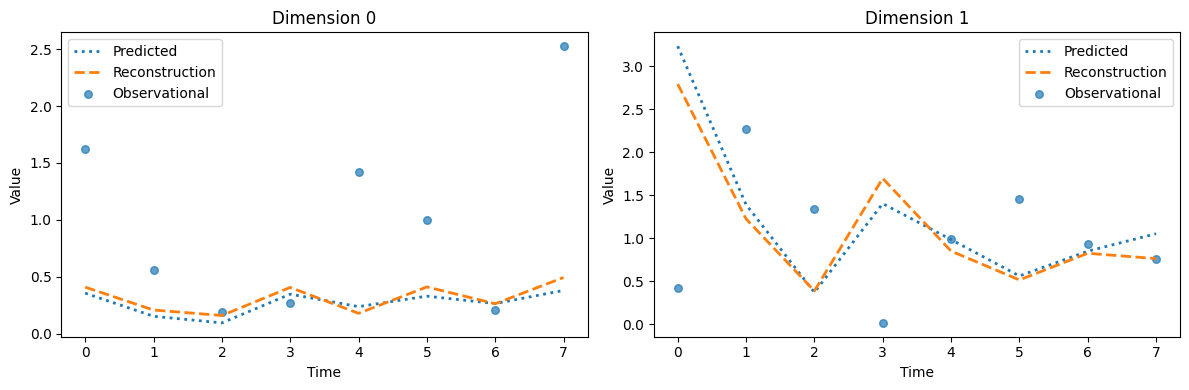

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

pred_np  = np.asarray(pred_np)      # (8, 2)
recon_np = np.asarray(recon_np)     # (8, 2)
obs = np.asarray(transform(lotka_abc.raw_observational_data))

t_pred = np.arange(pred_np.shape[0])
t_obs  = np.arange(obs.shape[0])

for d in range(2):
    # Predicted (dotted line)
    ax[d].plot(
        t_pred,
        pred_np[:, d],
        linestyle=":",
        linewidth=2,
        label="Predicted",
    )

    # Reconstructed (dotted line, different pattern)
    ax[d].plot(
        t_pred,
        recon_np[:, d],
        linestyle="--",
        linewidth=2,
        label="Reconstruction",
    )

    # Observational data (dots)
    ax[d].scatter(
        t_obs,
        obs[:, d],
        s=30,
        alpha=0.7,
        label="Observational",
    )

    ax[d].set_title(f"Dimension {d}")
    ax[d].set_xlabel("Time")
    ax[d].set_ylabel("Value")
    ax[d].legend()

plt.tight_layout()
plt.show()


In [18]:
original_np = transform(x)

In [19]:
lotka_abc.run(num_particles=100, k=10, q_threshold=0.999, max_generations=40)

INFO:src.viaABC.viaABC:Starting viaABC run with Q Threshold: 0.999
INFO:src.viaABC.viaABC:Initialization (generation 0) started
INFO:src.viaABC.viaABC:Initialization completed in 4.36 seconds
INFO:src.viaABC.viaABC:Mean: [2.0165 2.2725]
INFO:src.viaABC.viaABC:Median: [1.3773 1.2284]
INFO:src.viaABC.viaABC:Variance: [4.0494 6.9575]
INFO:src.viaABC.viaABC:Generation 1 started
100%|██████████| 100/100 [00:02<00:00, 43.02it/s]
INFO:src.viaABC.viaABC:Epsilon : 0.48732
INFO:src.viaABC.viaABC:Quantile : 0.73558
INFO:src.viaABC.viaABC:Simulations : 463
INFO:src.viaABC.viaABC:Mean: [1.8241 1.1937]
INFO:src.viaABC.viaABC:Median: [1.4390 0.9282]
INFO:src.viaABC.viaABC:Variance: [2.0264 1.4117]
INFO:src.viaABC.viaABC:Generation 1 completed in 2.69 seconds
INFO:src.viaABC.viaABC:Generation 2 started
100%|██████████| 100/100 [00:01<00:00, 68.49it/s]
INFO:src.viaABC.viaABC:Epsilon : 0.30032
INFO:src.viaABC.viaABC:Quantile : 0.72702
INFO:src.viaABC.viaABC:Simulations : 284
INFO:src.viaABC.viaABC:Mean:

KeyboardInterrupt: 